<font size=5> **Plotting sea ice in the Southern Ocean** </font>  
  
This script produces plots of sea ice area around the Southern Ocean using outputs from ACCESS-OM2-01. Comparison with observations is done using NASA Goddard passive microwave sea ice concentration data.  
  
**Requirements:** It is suggested you use the `conda/analysis3-20.07` (or later). This can be defined using the drop down list on the left hand corner, or type `!module load conda/analysis3` in a code cell.

# Loading relevant modules
These modules are used to access relevant outputs and to manipulate data. 

In [1]:
import cosima_cookbook as cc
import xarray as xr
import numpy as np
import pandas as pd
from dask.distributed import Client, progress
import os
from glob import glob
import re
from collections import OrderedDict
# from datetime import datetime
import calendar
#Importing script containing functions developed to calculate timeseries
import ZonalStatsFunctions as zsf
import netCDF4 as nc
import datetime as dt
import cftime
import xesmf as xe
import rioxarray

The following modules are used in plotting maps and time series.

In [2]:
#Packages for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.gridspec as gridspec
import matplotlib.cm as mcm
import geopandas

#This first line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

# Accessing ACCESS-OM2-01 outputs
Start a cluster that has multiple cores to work with. Remember that the number of cores cannot exceed the number of CPUs requested when accessing GADI.  
If the line below does not run, skip it. The result is that the job will not be parallelised, but the script will still run.

In [3]:
client = Client(n_workers = 8)

Access the default database of experiments from where data will be loaded.

In [4]:
session = cc.database.create_session()

This notebook uses the outputs for the v140 run of ACCESS-OM2-01 which includes wind forcing. Includes experiments `01deg_jra55v140_iaf` and `01deg_jra55v140_iaf`. A list of experiments can be accessed using `cc.querying.get_experiments(session)`, you can get a detailed list of experiments by adding `all = True` argument.

## Finding experiment variable names (Optional step)
You can query the temporal frequency of all variables available in the experiment using `cc.querying.get_frequencies(session, experiment)`. A list of experiment variables can be obtained using `cc.querying.get_variables(session, experiment, frequency)`.

In [1]:
#Activate the lines below to query temporal frequency
cc.querying.get_frequencies(session, varDict['expt'])

Query experiment variables list

In [11]:
#Querying experiment variables
expvar = cc.querying.get_variables(session, exp, frequency = "1 monthly")

#Extract variables with keywords included in its long_name column
expvar[expvar["long_name"].str.lower().str.match(".*ice.*")] #force all letters to be lowercase to get matches

name                                          long_name  \
5               Sinz_m                         ice internal bulk salinity   
8               Tinz_m             ice internal temperatures on CICE grid   
9               Tsfc_m                       snow/ice surface temperature   
12               VGRDi                                vertical ice levels   
14              aice_m                              ice area  (aggregate)   
15             aicen_m                               ice area, categories   
25             blkmask                                ice grid block mask   
29            congel_m                             congelation ice growth   
36          dvirdgdt_m                            ice volume ridging rate   
53            frazil_m                                  frazil ice growth   
54             fresh_m                      freshwtr flx ice to ocn (cpl)   
56          fsalt_ai_m                             salt flux ice to ocean   
57             fsalt_m                         salt flux ice to ocn (cpl)   
62                hi_m                       grid cell mean ice thickness   
64               lprec  liquid precip (including ice melt/form) into o...   
66                melt  water flux transferred with sea ice form/melt ...   
67             meltb_m                                     basal ice melt   
69             meltt_m                                       top ice melt   
70             mh_flux  heat into ocean due to melting ice (>0 heats o...   
96   sfc_salt_flux_ice                                  sfc_salt_flux_ice   
99            snoice_m                                 snow-ice formation   
102          strairx_m                                 atm/ice stress (x)   
103          strairy_m                                 atm/ice stress (y)   
104         strength_m                           compressive ice strength   
105          strocnx_m                               ocean/ice stress (x)   
106          strocny_m                               ocean/ice stress (y)   
137             uvel_m                                   ice velocity (x)   
141            vicen_m                             ice volume, categories   
142             vvel_m                                   ice velocity (y)   
143            wfiform  water out of ocean due to ice form (>0 enters ...   
144            wfimelt  water into ocean due to ice melt (>0 enters oc...   

     frequency                                             ncfile  # ncfiles  \
5    1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc         60   
8    1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc         60   
9    1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        732   
12   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc         60   
14   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        732   
15   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        732   
25   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        732   
29   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        732   
36   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        573   
53   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        732   
54   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        573   
56   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        732   
57   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        732   
62   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        732   
64   1 monthly  output487/ocean/ocean-2d-lprec-1-monthly-mean-...        244   
66   1 monthly  output487/ocean/ocean-2d-melt-1-monthly-mean-y...        244   
67   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        573   
69   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        573   
70   1 monthly  output487/ocean/o

In [19]:
#Deleting variables no longer in use
del expvar

['2000-02', '2001-02', '2002-02', '2003-02', '2004-02', '2005-02', '2006-02', '2007-02', '2008-02', '2009-02', '2010-02', '2011-02', '2012-02', '2013-02', '2014-02', '2015-02', '2016-02', '2017-02', '2018-02'] ['2001-01', '2002-01', '2003-01', '2004-01', '2005-01', '2006-01', '2007-01', '2008-01', '2009-01', '2010-01', '2011-01', '2012-01', '2013-01', '2014-01', '2015-01', '2016-01', '2017-01', '2018-01', '2019-01']


## Set up variable dictionary prior ACCESS-OM2 model outputs
Once the correct experiment variables have been identified, data can be loaded into the notebook for further processing. All variables needed to do this are included below.

In [4]:
varDict =  {'var_id': 'aice_m',
            'model': 'ACCESS-OM2-01',
             'expt': '01deg_jra55v140_iaf_cycle2', # ACCESS-OM2-01 cycle 2
             'freq': '1 monthly',
             'start_date': range(1965, 2018, 1),
             'offset': np.nan,
             'long_name': 'sea ice area',
             'short_name': 'SIA',
             'unit': '$m^2$',
             'CICE_data': True,
             'base_data': r'/g/data/v45/la6889/Calculations/SeaIceArea/Data',
             'climatologies': r'/g/data/v45/la6889/Calculations/SeaIceArea/Climatologies',
             'clim_fig': r'/g/data/v45/la6889/Figures/SeaIceArea/Climatologies',
             'linear_trends': r'/g/data/v45/la6889/Calculations/SeaIceArea/LinearTrends',
             'lm_fig': r'/g/data/v45/la6889/Figures/SeaIceArea/LinearTrends',
             'clipped_data': r'/g/data/v45/la6889/Calculations/SeaIceArea/ClippedMEASOregions/',
             'weighted_means_season': r'/g/data/v45/la6889/Calculations/SeaIceArea/YearlySeasonal/Means',
             'weighted_means_monthly': r'/g/data/v45/la6889/Calculations/SeaIceArea/YearlyMonthly/Means',
             'weighted_std_monthly': r'/g/data/v45/la6889/Calculations/SeaIceArea/YearlyMonthly/StdDev',
             'decades': range(1965, 2019, 10),
             'weighted_means_dec_season': r'/g/data/v45/la6889/Calculations/SeaIceArea/DecadalSeasonal/Means',
             'weighted_means_dec_monthly': r'/g/data/v45/la6889/Calculations/SeaIceArea/DecadalMonthly/Means',
             'mean_sector_time_series': r'/g/data/v45/la6889/Figures/SeaIceArea/TimeSeries/MEASO',
             'res': '0.1°'}

## Accessing ACCESS-OM2 outputs and saving results to disk

In [49]:
dir_out = varDict['base_data']
os.makedirs(dir_out, exist_ok = True)

for yr in varDict['decades']:
    #Accessing data per decade
    stime = f'{str(yr)}-01'
    etime = f'{str(yr+9)}-12'
    #Accessing ACCESS 0.1deg outputs for the entire time range of interest
    SO = zsf.getACCESSdata(varDict['var_id'], stime, etime,
                           freq = varDict['freq'], 
                           ses = session, minlat = -80, maxlat = -35,
                           ice_data = True)
    #Correcting longitudes
    SO = zsf.corrlong(SO)
    #Creating name of file    
    fn = f'SeaIceConcentration_{str(yr)}-{str(yr+9)}.nc'
    #Saving file
    SO.to_netcdf(os.path.join(dir_out, fn))

### Loading longitude corrected sea ice concentration data from disk

In [5]:
#Get list of files in disk
filelist = sorted(glob(os.path.join(varDict['base_data'], '*Conc*.nc')))

#Empty list to store files
SIC = []

#Loading single files
for file in filelist:
    SIC.append(xr.open_dataarray(file))

#Concantenating all files into a single data array
SIC = xr.concat(SIC, dim = 'time')

# Loading MEASO regions to overlay them on plots

<AxesSubplot:>

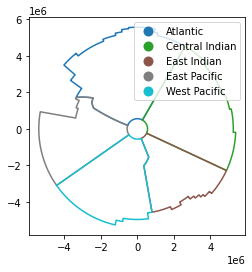

In [7]:
#Load shapefile
MEASO = geopandas.read_file('/g/data/v45/la6889/GIS_DataBase/Shapefiles/MEASO/measo.shp')

#Remove temperate zones as they are not within area of interest
MEASO = MEASO.query('zone != "Temperate"')

#Get sector names from shapefile
sectors = np.unique(MEASO.sector)

#Merge sectors within regions as sea ice is mostly within Antarctic areas
for i, sec in enumerate(sectors):
    pol = MEASO.query(f'sector == "{sec}"').geometry.unary_union
    pol_gs = geopandas.GeoSeries(pol).exterior
    if i == 0:
        MEASO_fixed = pol_gs
    else:
        MEASO_fixed = MEASO_fixed.append(pol_gs)

#Transforming geoseries into geodataframe to add region names
#and adding a new column with the names of the sectors
MEASO_fixed = geopandas.GeoDataFrame(geometry = MEASO_fixed).\
assign(sector = sectors)
        
#Checking results
MEASO_fixed.plot(column = 'sector', legend = True)

# Calculating climatologies for variable of interest across the Southern Ocean
The satellite period (1979-2008) was chosen to calculate climatologies, and three climatologies were calculated:
- Overall, which includes the mean for the entire climatological period
- Seasonal, which is the mean value per season over the climatological period
- Monthly, which is the mean monthly value over the climatological period

Calculations are done in this way to avoid issues with memory.

In [75]:
clim_overall = zsf.climCalc(SIC, [1979, 2008], clim_type = 'overall', 
                            varname = varDict['short_name'],
                            folder_out = varDict['climatologies'])
clim_seasonal = zsf.climCalc(SIC, [1979, 2008], clim_type = 'seasonal', 
                             varname = varDict['short_name'],
                             folder_out = varDict['climatologies'])
clim_monthly = zsf.climCalc(SIC, [1979, 2008], clim_type = 'monthly', 
                            varname = varDict['short_name'],
                            folder_out = varDict['climatologies'])

## Loading climatologies and plotting them

### Overall Climatology

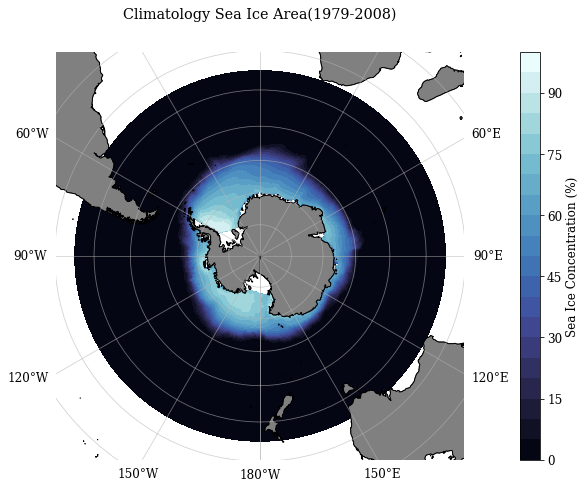

In [84]:
folder = os.path.join(varDict['climatologies'], '*overall*.nc')
fn = glob(folder)[0]

clim_overall = xr.open_dataarray(fn)*100

#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 7.5))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

levels = np.arange(0, 101, 5)

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', 
                                   linewidth = 0.5)

ax = fig.add_subplot(111, projection = projection)

#Add contour plot of sea ice advance
p = clim_overall.plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', levels = levels,
                                 ax = ax, cmap = cm.cm.ice, 
                                transform = ccrs.PlateCarree(), 
                                add_colorbar = False)

#Add land and coastlines
ax.add_feature(land_50m)
ax.coastlines(resolution = '50m')

#Apply colourbar to figure and set it to be horizontal
cb = fig.colorbar(p, ax = ax, label = 'Sea Ice Concentration (%)', pad = 0.1)

#Add title
ax.set_title('Climatology ' + varDict['long_name'].title() + '(1979-2008)')

#Draw gridlines
gl = ax.gridlines(draw_labels = True, y_inline = False, color = "#b4b4b4", alpha = 0.6)
#Locate longitude ticks - Set to every 30 deg
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
#Give longitude labels the correct format for longitudes
gl.xformatter = LONGITUDE_FORMATTER
#Set rotation of longitude labels to zero
gl.xlabel_style = {'rotation': 0}
#Set latitude labels to be transparent
gl.ylabel_style = {'alpha': 0}
#Add space between axis ticks and labels for x and y axes
gl.xpadding = 9
gl.ypadding = 9
gl.xlabels_left = False
gl.xlabels_right = True
gl.xlabels_top = False

#Remove the outside frame and ticklines of the figure
[s.set_visible(False) for s in ax.spines.values()]
[t.set_visible(False) for t in ax.get_xticklines()]
[t.set_visible(False) for t in ax.get_yticklines()]

fn = 'OverallClimatology_SeaIceConcentration_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

### Seasonal Climatology

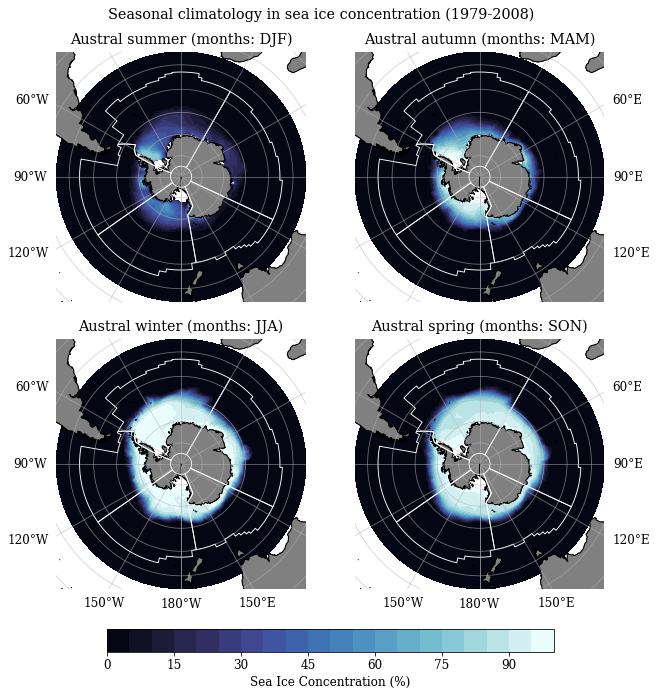

In [231]:
folder = os.path.join(varDict['climatologies'], '*seasonal*.nc')
fn = glob(folder)[0]

clim_seasonal = xr.open_dataarray(fn)*100

#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

levels = np.arange(0, 101, 5)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonName = {'DJF': 'Austral summer', 'MAM': 'Austral autumn', 
              'JJA': 'Austral winter', 'SON': 'Austral spring'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.15)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'DJF'), (0, 1, 'MAM'), (1, 0, 'JJA'), (1, 1, 'SON')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    p1 = (clim_seasonal.sel(season = season)).\
    plot.contourf(x = 'xt_ocean', y = 'yt_ocean', ax = ax[season], 
                  cmap = cm.cm.ice, levels = levels,
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree(), add_colorbar = False)
    MEASO_fixed.plot(color = 'white', lw = 0.9, ax = ax[season])
    
    #Set title for each subplot.
    ax[season].set_title(seasonName[season] + ' (months: ' + season + ')', y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
        
    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.8, pad = 0.06, 
                  label = 'Sea Ice Concentration (%)')
    
fig.suptitle('Seasonal climatology in sea ice concentration (1979-2008)', 
             y = 0.93)

fn = 'SeasonalClimatology_SeaIceConcentration_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

### Monthly Climatology

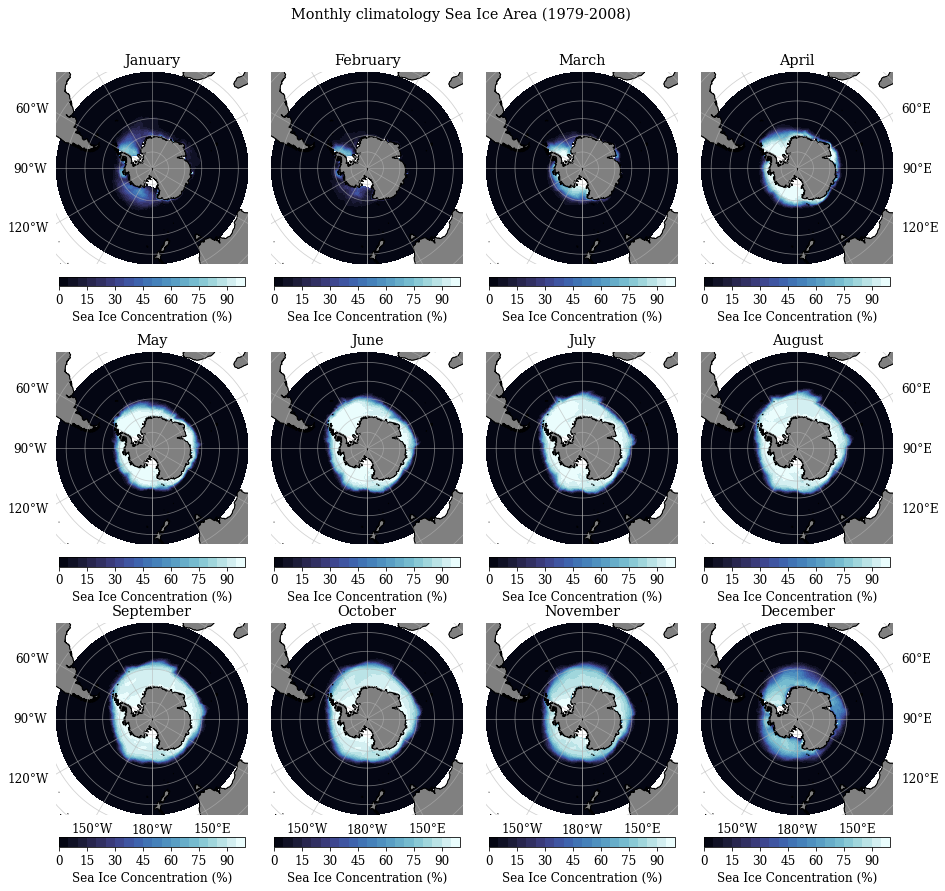

In [92]:
folder = os.path.join(varDict['climatologies'], '*month*.nc')
fn = glob(folder)[0]

clim_monthly = xr.open_dataarray(fn)*100

#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (15, 15))

levels = np.arange(0, 101, 5)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor = 'black', facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 3, ncols = 4)
#Change the width between each plot
gs.update(wspace = 0.12, hspace = 0.1)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for n, m in enumerate(clim_monthly.month.values):
    ax[m] = fig.add_subplot(gs[n], projection = projection)
    #Extract information for each season and start plotting
    p1 = (clim_monthly.sel(month = m)).\
    plot.contourf(x = 'xt_ocean', y = 'yt_ocean', ax = ax[m], 
                  cmap = cm.cm.ice, levels = levels,
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree(), add_colorbar = False)
        
    #Set title for each subplot.
    ax[m].set_title(calendar.month_name[m], y = 1.01)
    #Remove x and y axes labels
    ax[m].set_ylabel("")
    ax[m].set_xlabel("")
      
    #Add land and coastlines
    ax[m].add_feature(land_50m)
    ax[m].coastlines(resolution = '50m')
        
    #Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
    if n not in [8, 9, 10, 11]:
        cb = fig.colorbar(p1, ax = ax[m], orientation = 'horizontal', 
                          shrink = 0.97, pad = 0.05, 
                          label = 'Sea Ice Concentration (%)')
    else:
        cb = fig.colorbar(p1, ax = ax[m], orientation = 'horizontal', 
                          shrink = 0.97, pad = 0.09, 
                          label = 'Sea Ice Concentration (%)')

    #Draw gridlines
    gl = ax[m].gridlines(draw_labels = True, y_inline = False, 
                         color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    gl.xlabels_left = False
    gl.xlabels_right = False
    gl.xlabels_top = False
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    gl.ylabels_left = False
    if n in [0, 4]:
        gl.ylabels_left = True
    elif n in [3, 7]:
        gl.ylabels_right = True
    elif n == 8:
        gl.ylabels_left = True
        gl.xlabels_bottom = True
    elif n in [9, 10]:
        gl.xlabels_bottom = True
    elif n == 11:
        gl.ylabels_right = True
        gl.xlabels_bottom = True
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[m].spines.values()]
    [t.set_visible(False) for t in ax[m].get_xticklines()]
    [t.set_visible(False) for t in ax[m].get_yticklines()]

fig.suptitle('Monthly climatology ' + varDict['long_name'].title() + ' (1979-2008)', 
             y = 0.93)

fn = 'MonthlyClimatology_SeaIceConcentration_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

# Calculating linear trends in sea ice seasonality

## Defining seasons

In [8]:
seasonName = {'Summer': [12, 1, 2], 'Autumn': [3, 4, 5], 
              'Winter': [6, 7, 8], 'Spring': [9, 10, 11]}

## Separating data into seasons

In [9]:
climdata = SIC.sel(time = slice('1978-12', '2008-11'))

seasons_SIC = {}

for season in seasonName.keys():
    y = []
    for i, m in enumerate(climdata.time.dt.month.values.tolist()):
        if m in seasonName[season]:
            y.append(climdata[i])
    seasons_SIC[season] = xr.concat(y, dim = 'time')

## Calculating linear trends for model data

In [9]:
#Folder where linear trends will be saved
dir_out = varDict['linear_trends']
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Calculating linear trend for each season
for season in seasonName:
    #Define file name
    fn = f'LinearTrend_SIC_{season}_1979-2008.nc'

    #Extracting years to calculate linear trends
    time_ind = np.arange(0, len(seasons_SIC[season].time))
    #Extract values from SIC data and create a vector
    vals = seasons_SIC[season].values.reshape(len(time_ind), -1)

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = time_ind)

    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(seasons_SIC[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SIC[season].xt_ocean.values, 
                                        yt_ocean = seasons_SIC[season].yt_ocean.values),
                          name = "coefficients")

    pval_r = xr.DataArray(data = p.reshape(seasons_SIC[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SIC[season].xt_ocean.values, 
                                        yt_ocean = seasons_SIC[season].yt_ocean.values),
                          name = "p_values")

    LM_results = xr.merge([coef_r, pval_r])

    #Saving outputs
    LM_results.to_netcdf(os.path.join(dir_out, fn))

### Loading linear trends to avoid recalculating

In [8]:
filelist = glob(os.path.join(varDict['linear_trends'], '*.nc'))

LM_results = {}

for season in seasonName:
    file = [file for file in filelist if season in file]
    LM_results[season] = xr.open_dataset(file[0])

### Plotting linear trends per for model data
Linear trends calculated from observations and model outputs are given in proportion per year. When plotting, data is multiplied by 1000 to transform units of linear trends to percentage per decade.

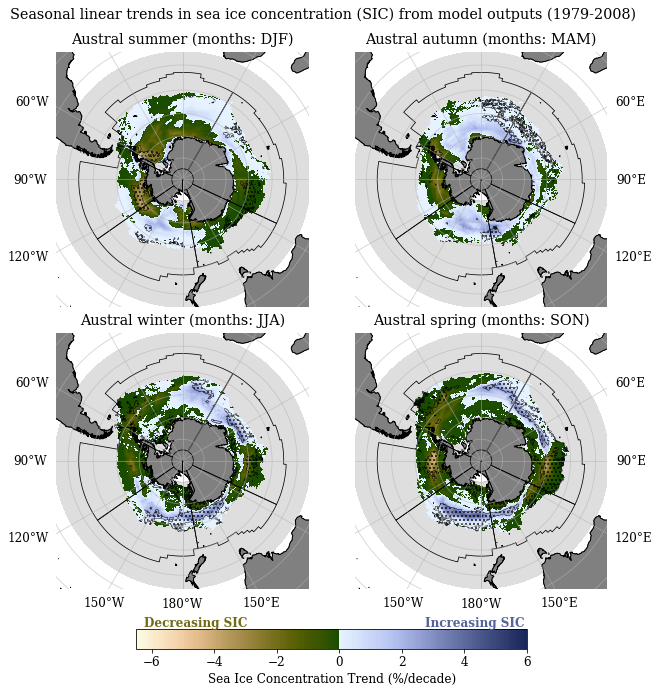

In [232]:
#Ensure folder where figures will be saved exists
folder_out = varDict['lm_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

# levels = np.arange(-6.5, 6.1, 0.5)
divnorm = mcolors.TwoSlopeNorm(vmin = -6.5, vcenter = 0, vmax = 6.0)
# col_map = cm.cm.tarn
col_map, col_map_r = zsf.colourMaps('../../ScientificColourMaps6/', 'oleron', rev = True)
col_map_r.set_bad('#dedede')

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonName = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.1)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    data = LM_results[season].coefficients*1000
    #Multiplying by 1000 to get percentages per decade
    p1 = data.where(data != 0, np.nan).plot.\
    pcolormesh(ax = ax[season], cmap = col_map_r, 
                              transform = ccrs.PlateCarree(), #levels = levels,
                              norm = divnorm, add_colorbar = False)
    MEASO_fixed.plot(color = 'black', lw = 0.75, ax = ax[season])
    #Plotting significance
    #Extracting only significant values >= 0.05
    sig = xr.where(LM_results[season].p_values <= 0.05, True, 0)
    #Add contour around significant areas
    sig.plot.contour(colors = 'black', transform = ccrs.PlateCarree(),
                     ax = ax[season], add_colorbar = False, linewidths = .1)
    #Adding hatching
    sig.where(sig == 1, np.nan).plot.contourf(hatches = ['...'],
                                              colors = 'none', ax = ax[season],
                                              transform = ccrs.PlateCarree(), 
                                              add_colorbar = False)

    #Set title for each subplot.
    ax[season].set_title(seasonName[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
    
    #Set map extent
    ax[season].set_extent([-180, 180, -90, -35], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.7, pad = 0.06, 
                  label = 'Sea Ice Concentration Trend (%/decade)')

#Add labels to improve readability
#Get colormap to extract colors for labels
cb.ax.text(2.75, 7.75, 'Increasing SIC', color = col_map_r(0.85), fontweight = 'bold')
cb.ax.text(-6.25, 7.75, 'Decreasing SIC', color = col_map_r(0.35), fontweight = 'bold')

fig.suptitle('Seasonal linear trends in sea ice concentration (SIC) from model outputs (1979-2008)', 
             y = 0.93)

fn = 'SeasonalLinearTrends_SeaIceConcentration_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

### Calculating standard deviation

In [10]:
std_season = {}

for season in seasons_SIC:
    std_season[season] = seasons_SIC[season].std('time')

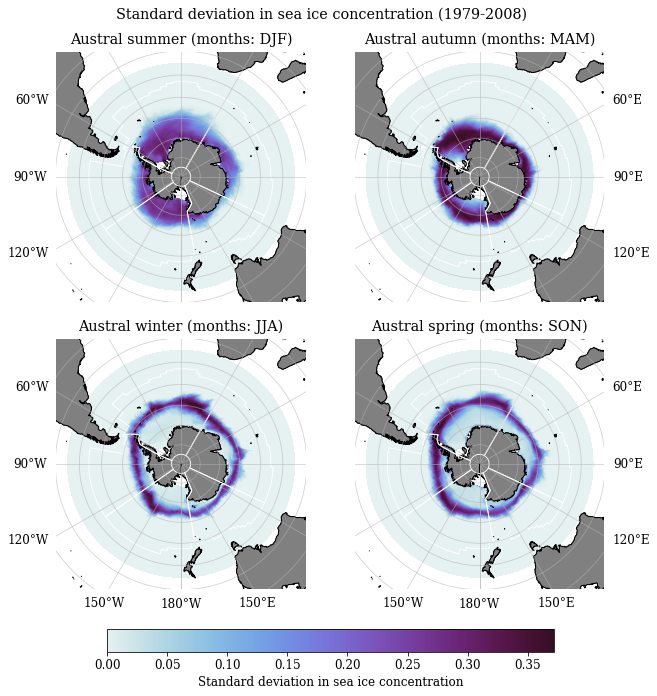

In [93]:
#Ensure folder where figures will be saved exists
folder_out = varDict['lm_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonName = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.15)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    p1 = std_season[season].plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = ax[season], 
                  cmap = cm.cm.dense,
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree(), add_colorbar = False)
    MEASO_fixed.plot(color = 'white', lw = 0.9, ax = ax[season])
    
    #Set title for each subplot.
    ax[season].set_title(seasonName[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
        
    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.8, pad = 0.06, 
                  label = 'Standard deviation in sea ice concentration')
    
fig.suptitle('Standard deviation in sea ice concentration (1979-2008)', 
             y = 0.93)

fn = 'StdDev_SeaIceConcentration_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

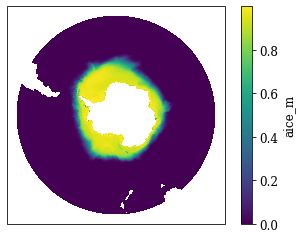

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
seasons_SIC['Winter'].mean('time').plot(ax = ax, transform = ccrs.PlateCarree())

## Calculating linear trends from observations

In [109]:
#Location of observation files
filelist = sorted(glob('/g/data/v45/la6889/Observations/*.nc'))

#Load them as data array
iceObs = []
for yr in range(1978, 2009):
    file = [f for f in filelist if str(yr) in f]
    data = xr.open_dataarray(file[0]).groupby('time.month').mean('time')
    time = pd.date_range(f'{yr}-{data.month.values.min()}', 
                         f'{yr}-{data.month.values.max()}', freq = 'MS')
    data = data.rename({'month': 'time'})
    data['time'] = time
    iceObs.append(data)
iceObs = xr.concat(iceObs, dim = 'time').sel(time = slice('1978-12', '2008-11'))

#Divide them into seasons
seasons_SIC_obs = {}
for season in seasonName.keys():
    y = []
    for i, m in enumerate(iceObs.time.dt.month.values.tolist()):
        if m in seasonName[season]:
            y.append(iceObs[i])
    seasons_SIC_obs[season] = xr.concat(y, dim = 'time')

In [13]:
#Folder where linear trends will be saved
dir_out = os.path.join(varDict['linear_trends'], 'Observations')
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Calculating linear trend for each season
for season in seasonName:
    #Define file name
    fn = f'LinearTrend_SIC_obs_{season}_1979-2008.nc'

    #Extracting years to calculate linear trends
    time_ind = np.arange(0, len(seasons_SIC_obs[season].time))
    #Extract values from SIC data and create a vector
    vals = seasons_SIC_obs[season].values.reshape(len(time_ind), -1)

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = time_ind)

    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(seasons_SIC_obs[season][0].shape), 
                          dims = ["ygrid", "xgrid"], 
                          coords = dict(xgrid = seasons_SIC_obs[season].xgrid.values, 
                                        ygrid = seasons_SIC_obs[season].ygrid.values),
                          name = "coefficients")

    pval_r = xr.DataArray(data = p.reshape(seasons_SIC_obs[season][0].shape), 
                          dims = ["ygrid", "xgrid"], 
                          coords = dict(xgrid = seasons_SIC_obs[season].xgrid.values, 
                                        ygrid = seasons_SIC_obs[season].ygrid.values),
                          name = "p_values")

    LM_results = xr.merge([coef_r, pval_r])

    #Saving outputs
    LM_results.to_netcdf(os.path.join(dir_out, fn))

### Loading linear trends from observations from disk to avoid recalculation

In [32]:
filelist = glob(os.path.join(varDict['linear_trends'], 'Observations/*.nc'))

LM_results_obs = {}

for season in seasonName:
    file = [file for file in filelist if season in file]
    LM_results_obs[season] = xr.open_dataset(file[0])
    LM_results_obs[season] = LM_results_obs[season].rename({'xgrid': 'x', 'ygrid': 'y'})

### Plotting linear trends from observations
Linear trends calculated from observations and model outputs are given in proportion per year. When plotting, data is multiplied by 1000 to transform units of linear trends to percentage per decade.

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '

  warnings.warn('The .ylabels_right attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '

  warnings.warn('The .ylabels_left attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .ylabels_right attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .ylabels_left attribute is deprecated. Please '



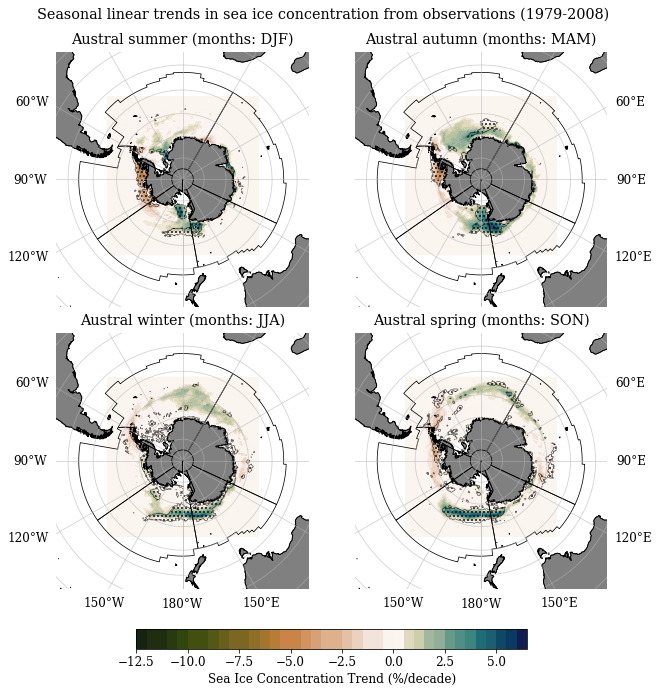

In [168]:
#Ensure folder where figures will be saved exists
folder_out = os.path.join(varDict['lm_fig'], 'Observations')
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

levels = np.arange(-12.5, 6.6, 0.5)

divnorm = mcolors.TwoSlopeNorm(vmin = -12.5, vcenter = 0, vmax = 6.5)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonName = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.1)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    data = LM_results_obs[season].coefficients*1000
    #Multiplying by 1000 to get percentages per decade
    p1 = data.plot.pcolormesh(ax = ax[season], cmap = cm.cm.tarn, norm = divnorm,
                              levels = levels, add_colorbar = False)
    MEASO_fixed.plot(color = 'black', lw = 0.75, ax = ax[season])
    #Plotting significance
    #Extracting only significant values >= 0.05
    sig = xr.where(LM_results_obs[season].p_values <= 0.05, True, 0)
    #Add contour around significant areas
    sig.plot.contour(colors = 'black',
                     ax = ax[season], add_colorbar = False, linewidths = .1)
    #Adding hatching
    sig.where(sig == 1, np.nan).plot.contourf(hatches = ['...'],
                                              colors = 'none', ax = ax[season],
                                              add_colorbar = False)

    #Set title for each subplot.
    ax[season].set_title(seasonName[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
    
    #Set map extent
    ax[season].set_extent([-180, 180, -90, -35], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.7, pad = 0.06, 
                  label = 'Sea Ice Concentration Trend (%/decade)')
fig.suptitle('Seasonal linear trends in sea ice concentration from observations (1979-2008)', 
             y = 0.93)

fn = 'SeasonalLinearTrends_Obs_SeaIceConcentration_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

## Comparing linear trends from observations and model outputs
Linear trends calculated from observations and model outputs are given in proportion per year. When plotting, data is multiplied by 1000 to transform units of linear trends to percentage per decade.

### Reprojecting model outputs to observation CRS

In [33]:
#Empty dictionary that will hold reprojected observations data
LM_obs_reproj = {}
LM_mod = {}

for key in LM_results_obs:
    obs = LM_results_obs[key].coefficients
    LM_obs_reproj[key] = zsf.reproject_latlon_coords(obs, 'epsg:3976', 'epsg:4326')
    mod = LM_results[key].coefficients.sel(yt_ocean = slice(-90, -50))
    LM_mod[key] = mod.rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'})

### Regridding of model outputs to match observations (coarsening data) and calculating trend differences
When plotting the regridded model outputs, the y axis must be inverted for the map to show the right way up. This can be done by adding the following line after plotting: `plt.gca().invert_yaxis()`.

In [35]:
#Ensuring folder to save regridded data exists
folder_out = os.path.join(varDict['linear_trends'], 'Regridded')
os.makedirs(folder_out, exist_ok = True)

#Regridder only calculated once as the same will be applied for all seasons
reg_coarse = xe.Regridder(LM_mod[key], LM_obs_reproj[key], 'bilinear')

#Empty dictionary that will hold reprojected observations data
LM_dif_obs_mod = {}
LM_dirdif_obs_mod = {}

for key in LM_mod:
    #Regridding model data
    mod_c = reg_coarse(LM_mod[key])
    #Saving regridded data
    fn = f'LinearTrend_SIC_regridded-mod_{key}_1979-2008.nc'
    mod_c.to_netcdf(os.path.join(folder_out, fn))
    #Calculating differences
    LM_dif_obs_mod[key] = LM_results_obs[key].coefficients - mod_c
    #Saving differences (obs - mod)
    fn_magdif = f'DifMag_LinearTrend_SIC_obs-mod_{key}_1979-2008.nc'
    LM_dif_obs_mod[key].to_netcdf(os.path.join(folder_out, fn_magdif))
    
    #Calculating differences in direction
    #Observations
    obs_dir = xr.where(LM_results_obs[key].coefficients > 0, 1, -1)
    obs_dir = xr.where(LM_results_obs[key].coefficients == 0, 0, obs_dir)
    obs_dir = xr.where(np.isnan(LM_results_obs[key].coefficients), np.nan, obs_dir)
    #Model outputs
    mod_dir = xr.where(mod_c > 0, 1, -1)
    mod_dir = xr.where(mod_c == 0, 0, mod_dir)
    mod_dir = xr.where(np.isnan(mod_c), np.nan, mod_dir)
    #Difference in direction
    LM_dirdif_obs_mod[key] = obs_dir-mod_dir
    #Saving results
    fn_dirdif = f'DifDir_LinearTrend_SIC_obs-mod_{key}_1979-2008.nc'
    LM_dirdif_obs_mod[key].to_netcdf(os.path.join(folder_out, fn_dirdif))

#### Loading differences from disk to avoid recalculation

In [36]:
#Getting files of magnitude and direction differences
filesDirDif = sorted(glob(os.path.join(varDict['linear_trends'], 'Regridded/DifDir*.nc')))
filesMagDif = sorted(glob(os.path.join(varDict['linear_trends'], 'Regridded/DifMag*.nc')))

#Empty dictionary that will hold reprojected observations data
LM_dif_obs_mod = {}
LM_dirdif_obs_mod = {}

for season in seasonName:
    fileDir = [fd for fd in filesDirDif if season in fd]
    fileMag = [fm for fm in filesMagDif if season in fm]
    LM_dif_obs_mod[season] = xr.open_dataarray(fileMag[0])
    LM_dirdif_obs_mod[season] = xr.open_dataarray(fileDir[0])

### Plotting differences in trend magnitude between observations and model outputs

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '

  warnings.warn('The .ylabels_right attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '

  warnings.warn('The .ylabels_left attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .ylabels_right attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .ylabels_left attribute is deprecated. Please '



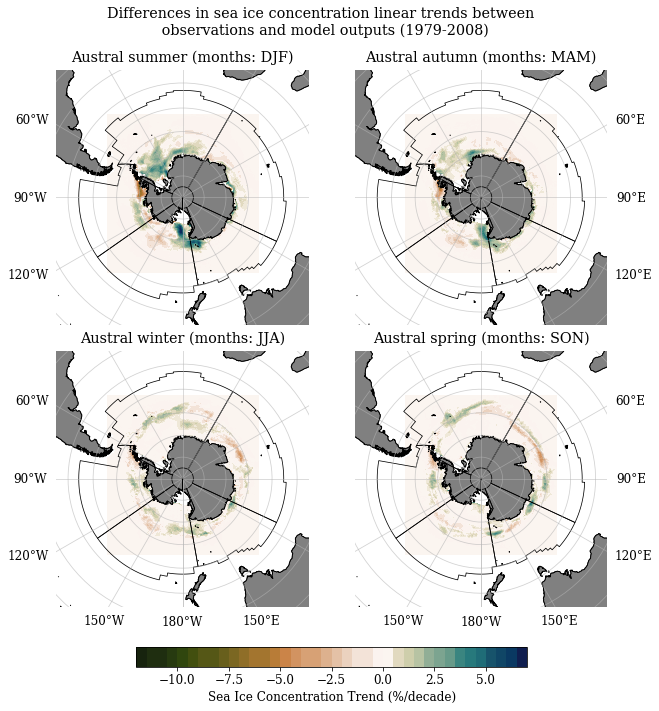

In [169]:
#Ensure folder where figures will be saved exists
folder_out = varDict['lm_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

levels = np.arange(-12, 7.1, 0.5)

divnorm = mcolors.TwoSlopeNorm(vmin = -12, vcenter = 0, vmax = 7)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonName = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.1)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    data = LM_dif_obs_mod[season]*1000
    #Multiplying by 1000 to get percentages per decade
    p1 = data.plot.pcolormesh(ax = ax[season], cmap = cm.cm.tarn, norm = divnorm,
                              levels = levels, add_colorbar = False)
    MEASO_fixed.plot(color = 'black', lw = 0.75, ax = ax[season])

    #Set title for each subplot.
    ax[season].set_title(seasonName[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
    
    #Set map extent
    ax[season].set_extent([-180, 180, -90, -35], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.7, pad = 0.06, 
                  label = 'Sea Ice Concentration Trend (%/decade)')
fig.suptitle('Differences in sea ice concentration linear trends between \n observations and model outputs (1979-2008)', 
             y = 0.95)

fn = 'Diffs_Obs-Mod_SeasonalTrends_SeaIceConcentration_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

### Plotting differences in trend direction between observations and model outputs

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '

  warnings.warn('The .ylabels_right attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '

  warnings.warn('The .ylabels_left attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .ylabels_right attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .ylabels_left attribute is deprecated. Please '



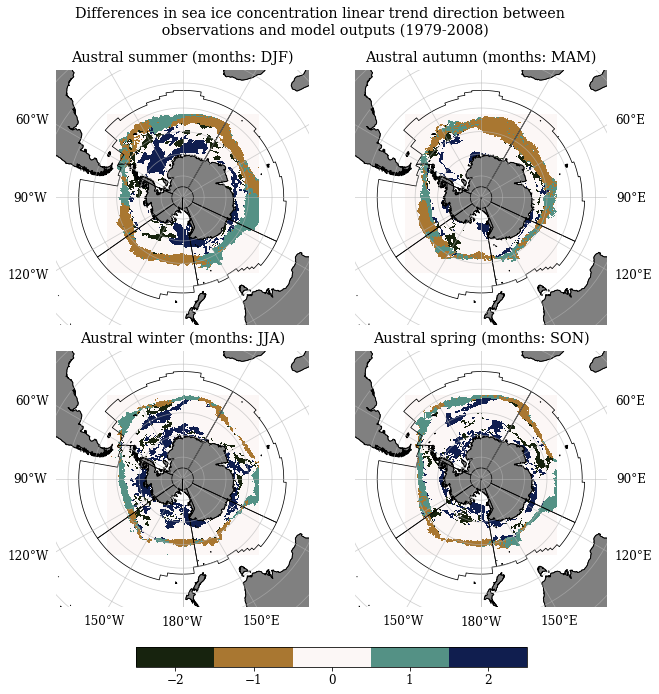

In [170]:
#Ensure folder where figures will be saved exists
folder_out = varDict['lm_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonName = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)
########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.1)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    data = LM_dirdif_obs_mod[season]
    #Creating a colorbar from 'tarn' that contains five levels
    cmap = plt.get_cmap(cm.cm.tarn, 5)
    #Multiplying by 1000 to get percentages per decade
    p1 = data.plot.pcolormesh(ax = ax[season], cmap = cmap, 
                              #Levels and limits are 0.5 units wider than 
                              #actual measurements
                              levels = np.arange(-2.5, 2.6, 1),
                              vmin = -2.5, vmax = 2.5,
                              add_colorbar = False)
    MEASO_fixed.plot(color = 'black', lw = 0.75, ax = ax[season])

    #Set title for each subplot.
    ax[season].set_title(seasonName[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
    
    #Set map extent
    ax[season].set_extent([-180, 180, -90, -35], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.7, pad = 0.06, 
                  #Ticks in colorbar match the data range
                  ticks = np.arange(-2, 2.1),
                  label = '')
fig.suptitle('Differences in sea ice concentration linear trend direction between \n observations and model outputs (1979-2008)', 
             y = 0.95)

fn = 'DirDiffs_Obs-Mod_SeasonalTrends_SeaIceConcentration_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

# Calculating Sea Ice Extent (SIE)
Sea ice extent is calculated based on Hobbs et al 2016, which is the total area covered where sea ice concentration is 15% or more.

In [75]:
#Loading ice area data (in m2) - Only one file needed as they will be the same regardless of the time
IceArea = xr.open_dataarray('/g/data/v45/la6889/Calculations/Area_per_pixel_01deg/area_per_pixel_01deg_all_areas.nc')

## SIE from model outputs

In [78]:
#Ensure output folder exists
folder_out = varDict['base_data']
os.makedirs(folder_out, exist_ok = True)

#Only keep area pixels where sea ice concentration is 15% or more
SIE = xr.where(SIC >= 0.15, IceArea, np.nan)

#Save sea ice extent
fn = f'SeaIceExtent_{SIE.time.dt.year.values.min()}-{SIE.time.dt.year.values.max()}.nc'
SIE.to_netcdf(os.path.join(folder_out, fn))

### Loading sea ice extent to avoid recalculation

In [7]:
SIE = xr.open_dataarray(glob(os.path.join(varDict['base_data'], '*Ext*.nc'))[0])

## SIE from observations

In [8]:
#Location of observation files
filelist = sorted(glob('/g/data/v45/la6889/Observations/*.nc'))

#Load them as data array
iceObs = []
for yr in range(1978, 2009):
    file = [f for f in filelist if str(yr) in f]
    data = xr.open_dataarray(file[0]).groupby('time.month').mean('time')
    time = pd.date_range(f'{yr}-{data.month.values.min()}', 
                         f'{yr}-{data.month.values.max()}', freq = 'MS')
    data = data.rename({'month': 'time'})
    data['time'] = time
    iceObs.append(data)
iceObs = xr.concat(iceObs, dim = 'time').sel(time = slice('1978-12', '2008-11'))

#Only keep area pixels where sea ice concentration is 15% or more
SIE_obs = xr.where(iceObs >= 0.15, (25000**2), np.nan)

## Splitting data into MEASO regions

In [7]:
#Defining sector names in order
sectorNames = ['East Pacific', 'Atlantic', 'Central Indian', 'East Indian', 'West Pacific']

In [11]:
#Loading mask
regions = xr.load_dataarray('MEASO_SIS_3Dmask.nc')

#Subsetting shapefiles into regions - Initialise dictionary that will contain sector limits
MEASOregions = {}

#Saving each sector as an entry in the dictionary
for i in sectorNames:
    MEASOregions[i] = regions.sel(region = i)
    
MEASOregions.keys()

dict_keys(['East Pacific', 'Atlantic', 'Central Indian', 'East Indian', 'West Pacific'])

### Model outputs

In [12]:
#Ensuring output folder exists
out_folder = varDict['clipped_data']
#Ensuring file exists
os.makedirs(out_folder, exist_ok = True)

#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
clipped_SIE = {}

#Range of years included in data
minY = SIE.time.dt.year.values.min()
maxY = SIE.time.dt.year.values.max()

#Saving each sector as an entry in the dictionary
for sector in sectorNames:
    clip = []
    for t in SIE.time.values:
        sie_t = SIE.sel(time = t)
        sie_t = (sie_t*MEASOregions[sector]).sum(('xt_ocean', 'yt_ocean'))
        clip.append(sie_t)
    clipped_SIE[sector] = xr.concat(clip, dim = 'time')
    #Create name for output file
    fn = f'SeaIceExtent_{sector}_{minY}-{maxY}.nc'
    clipped_SIE[sector].to_netcdf(os.path.join(out_folder, fn))

#### Loading clipped data to avoid recalculation

In [8]:
filelist = glob(os.path.join(varDict['clipped_data'], '*.nc'))

#Create empty list to save clipped data 
clipped_SIE = {}

for sector in sectorNames:
    fn = [f for f in filelist if sector in f]
    clipped_SIE[sector] = xr.open_dataarray(fn[0])

### Observations

In [9]:
#Assigning CRS to MEASO regions
MEASO_fixed = MEASO_fixed.set_crs(epsg = 3976)

#Assigning CRS to observational data
SIE_obs.rio.set_spatial_dims(x_dim = 'xgrid', y_dim = 'ygrid', inplace = True)
SIE_obs.rio.write_crs(MEASO_fixed.crs, inplace = True)

<xarray.DataArray 'goddard_merged_seaice_conc' (time: 360, ygrid: 332, xgrid: 316)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * ygrid        (ygrid) float32 4.338e+06 4.312e+06 ... -3.912e+06 -3.938e+06
  * xgrid        (xgrid) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
    latitude     (ygrid, xgrid) float64 -39.36 -39.49 -39.62 ... -41.72 -41.58
    longitude    (ygrid, xgrid) float64 -42.23 -42.05 -41.87 ... 135.2 135.0
  * time         (time) datetime64[ns] 1978-12-01 1979-01-01 ... 2008-11-01
    spatial_ref  int64 0

In [10]:
#Ensuring output folder exists
out_folder = os.path.join(varDict['clipped_data'], 'Observations')
#Ensuring file exists
os.makedirs(out_folder, exist_ok = True)

#Range of years included in data
minY = SIE_obs.time.dt.year.values.min()
maxY = SIE_obs.time.dt.year.values.max()

#Empty list to store clipped data 
clipped_SIE_obs = {}

#Clipping data using MEASO sectors
for sec in np.unique(MEASO.sector):
    shp = MEASO.query(f'sector == "{sec}"')
    clipped_SIE_obs[sec] = SIE_obs.rio.clip(shp.geometry, invert = False)
    clipped_SIE_obs[sec] = clipped_SIE_obs[sec].sum(('xgrid', 'ygrid'))
    fn = f'SeaIceExtent_Obs_{sec}_{minY}-{maxY}.nc'
    clipped_SIE_obs[sec].to_netcdf(os.path.join(out_folder, fn))

#### Loading clipped observational data to avoid recalculation

In [14]:
filelist = glob(os.path.join(varDict['clipped_data'], 'Observations/*.nc'))

#Create empty list to save clipped data 
clipped_SIE_obs = {}

for sector in sectorNames:
    fn = [f for f in filelist if sector in f]
    clipped_SIE_obs[sector] = xr.open_dataarray(fn[0])

## Calculating mean monthly linear trends for sea ice extent

### From model outputs

In [17]:
folder_out = os.path.join(varDict['linear_trends'], 'Monthly')
os.makedirs(folder_out, exist_ok = True)

LM_month_sec = {}

for sec in clipped_SIE:
    sub = clipped_SIE[sec].sel(time = slice('1979', '2008'))
    #Range of years included in data
    minY = sub.time.dt.year.values.min()
    maxY = sub.time.dt.year.values.max()
    coef_s = []
    se_s = []
    r_s = []
    p_s = []
    for month in range(1, 13):
        data = []
        for i, m in enumerate(sub.time.dt.month.values.tolist()):
            if m == month:
                data.append(sub[i])
        data = xr.concat(data, dim = 'time')
        time_ind = np.arange(0, len(data))
        #Extract values from SIC data and create a vector
        vals = data.values.tolist()
        #Save coefficients and pvalues for linear regression calculations
        slope, intercept, r, p, se = zsf.lm_yr(vals, time_ind)
        
        #Reshaping coefficients and pvalues to original dimensions of the data array
        coef_s.append(xr.DataArray(data = slope, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "coefficients"))
        se_s.append(xr.DataArray(data = se, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "std_err"))
        r_s.append(xr.DataArray(data = r, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "r_sq"))
        p_s.append(xr.DataArray(data = p, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "p_val"))
    #Concatening values before creating a data set
    coef_s = xr.concat(coef_s, dim = 'month')
    se_s = xr.concat(se_s, dim = 'month')
    r_s = xr.concat(r_s, dim = 'month')
    p_s = xr.concat(p_s, dim = 'month')
    
    #Creating data set
    LM_month_sec[sec] = xr.merge([coef_s, se_s, r_s, p_s])
    fn = f'MonthlyLinearTrend_SIE_{sec}.nc'
    LM_month_sec[sec].to_netcdf(os.path.join(folder_out, fn))

### From observations

In [18]:
folder_out = os.path.join(varDict['linear_trends'], 'Monthly/Observations')
os.makedirs(folder_out, exist_ok = True)

LM_month_sec_obs = {}

for sec in clipped_SIE_obs:
    sub = clipped_SIE_obs[sec].sel(time = slice('1979', '2008'))
    #Range of years included in data
    minY = sub.time.dt.year.values.min()
    maxY = sub.time.dt.year.values.max()
    coef_s = []
    se_s = []
    r_s = []
    p_s = []
    for month in range(1, 13):
        data = []
        for i, m in enumerate(sub.time.dt.month.values.tolist()):
            if m == month:
                data.append(sub[i])
        data = xr.concat(data, dim = 'time')
        time_ind = np.arange(0, len(data))
        #Extract values from SIC data and create a vector
        vals = data.values.tolist()
        #Save coefficients and pvalues for linear regression calculations
        slope, intercept, r, p, se = zsf.lm_yr(vals, time_ind)
        
        #Reshaping coefficients and pvalues to original dimensions of the data array
        coef_s.append(xr.DataArray(data = slope, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "coefficients"))
        se_s.append(xr.DataArray(data = se, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "std_err"))
        r_s.append(xr.DataArray(data = r, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "r_sq"))
        p_s.append(xr.DataArray(data = p, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "p_val"))
    #Concatening values before creating a data set
    coef_s = xr.concat(coef_s, dim = 'month')
    se_s = xr.concat(se_s, dim = 'month')
    r_s = xr.concat(r_s, dim = 'month')
    p_s = xr.concat(p_s, dim = 'month')
    
    #Creating data set
    LM_month_sec_obs[sec] = xr.merge([coef_s, se_s, r_s, p_s])
    fn = f'MonthlyLinearTrend_Obs_SIE_{sec}.nc'
    LM_month_sec_obs[sec].to_netcdf(os.path.join(folder_out, fn))

#### Loading clipped data to avoid recalculation

In [14]:
filelist = glob(os.path.join(varDict['linear_trends'], 'Monthly/*.nc'))

#Create empty list to save clipped data 
LM_month_sec = {}

for sector in sectorNames:
    fn = [f for f in filelist if sector in f]
    LM_month_sec[sector] = xr.open_dataset(fn[0])

In [26]:
filelist = glob(os.path.join(varDict['linear_trends'], 'Monthly/Observations/*.nc'))

#Create empty list to save clipped data 
LM_month_sec_obs = {}

for sector in sectorNames:
    fn = [f for f in filelist if sector in f]
    LM_month_sec_obs[sector] = xr.open_dataset(fn[0])

## Plotting comparison of  monthly sea ice extent trends in model and observations

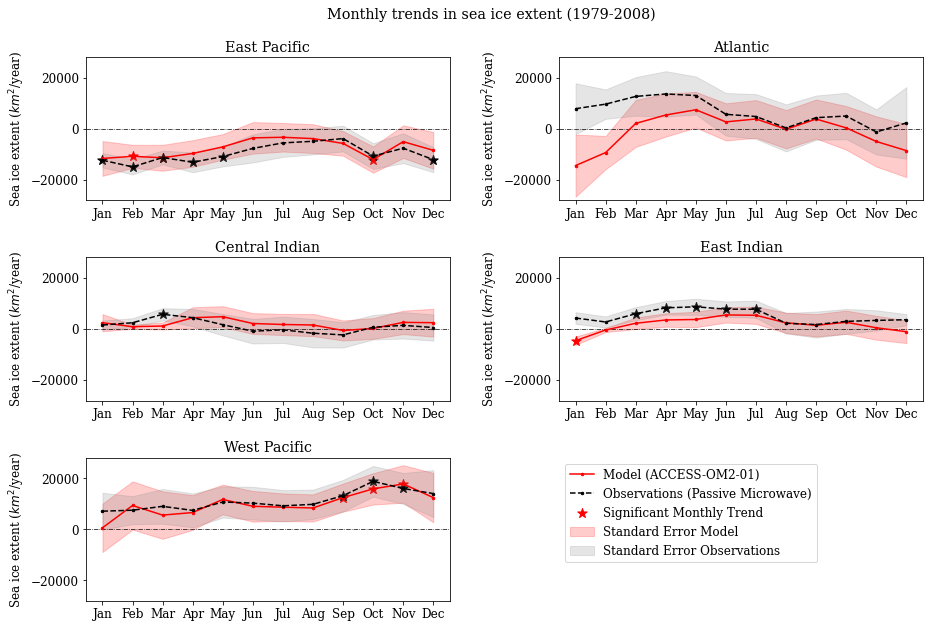

In [154]:
#Defining folder to save figure
out_folder = varDict['lm_fig']
os.makedirs(out_folder, exist_ok = True)

#Define max and min values for y axis
maxval = []
minval = []
for sec in LM_month_sec:
    data = LM_month_sec[sec]
    maxval.append((data.coefficients.max()+data.std_err.max()).values)
    minval.append((data.coefficients.min()-data.std_err.max()).values)
    data = LM_month_sec_obs[sec]
    maxval.append((data.coefficients.max()+data.std_err.max()).values)
    minval.append((data.coefficients.min()-data.std_err.max()).values)
#Calculating max and min values to the nearest ten
maxval, minval = [(np.ceil(max(maxval)) + (1e9 - np.ceil(max(maxval))%1e9)), 
                  (np.floor(min(minval)) + (-1e9 - np.floor(min(minval))%1e9))]

#Initialising figure
fig = plt.figure(figsize = (15, 10))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Create grid to show plots
gs = gridspec.GridSpec(nrows = 3, ncols = 2)

#Change the width between each plot
gs.update(wspace = 0.3, hspace = 0.4)

#Empty list to store axes 
ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, sec in enumerate(LM_month_sec):
    #Add each subplot
    ax[sec] = fig.add_subplot(gs[i])
    
    #Select data for each sector and change months to numeric values
    #Model data
    data = LM_month_sec[sec]
    data['month'] = np.arange(1, 13)
    #Observational data
    obs = LM_month_sec_obs[sec]
    obs['month'] = np.arange(1, 13)
    
    #Extract information for each season and start plotting
    #Values multiplied by 1e-6 to transform from m2 to km2
    #Model data
    coef = (data.coefficients*1e-6)
    se = (data.std_err*1e-6)
    sig = xr.where(data.p_val <= 0.05, coef, np.nan)
    
    #Observational data
    coef_obs = (obs.coefficients*1e-6)
    se_obs = (obs.std_err*1e-6)
    sig_obs = xr.where(obs.p_val <= 0.05, coef_obs, np.nan)
    
    #Plotting values
    #Model data
    #Adding horizontal line that makes it easier to distinguish positive and negative trends
    plt.axhline(y = 0, color = 'black', linestyle = '-.', lw = 0.7)
    #Add trends as lines and highlight significance with markers
    coef.plot(ax = ax[sec], color = 'red', marker = 'o', markersize = 2.5, 
              label = 'Model (ACCESS-OM2-01)')
    plt.scatter(coef.month.values, sig, marker = '*', s = 100, c = 'red', label = 'Significant Monthly Trend')
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(coef.month, (coef+se).values, (coef-se).values,
               alpha = 0.2, color = 'red', label = 'Standard Error Model')
    
    #Observational data
    coef_obs.plot(ax = ax[sec], color = 'black', ls = '--', marker = 'o', markersize = 2.5,
                 label = 'Observations (Passive Microwave)')
    plt.scatter(coef_obs.month.values, sig_obs, marker = '*', s = 100, c = 'black')
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(coef_obs.month, (coef_obs+se_obs).values, (coef_obs-se_obs).values,
               alpha = 0.2, color = 'gray', label = 'Standard Error Observations')
    
    #Remove x axis label
    ax[sec].set_xlabel('')
    ax[sec].set_ylabel('Sea ice extent ($km^{2}$/year)')
    #Setting title for each subplot
    ax[sec].set_title(f'{sec}')
    #Show all ticks along the x axis
    plt.xticks(np.arange(1, 13))
    #Label x ticks as months
    ax[sec].set_xticklabels(calendar.month_abbr[1:])
    #Set y axis limits
    ax[sec].set_ylim(minval*1e-6, (maxval*1e-6))
    
ax['legend'] = fig.add_subplot(gs[5])
h, l = ax[sec].get_legend_handles_labels()
ax['legend'].legend(h, l, loc = 'upper left')
[s.set_visible(False) for s in ax['legend'].spines.values()]
[t.set_visible(False) for t in ax['legend'].get_xticklines()]
[t.set_visible(False) for t in ax['legend'].get_yticklines()]
ax['legend'].yaxis.set_tick_params(labelleft = False)
ax['legend'].xaxis.set_tick_params(labelbottom = False)
    
#Adding title to overall figure
fig.suptitle('Monthly trends in sea ice extent (1979-2008)', y = 0.95)

#Saving figure
fn = 'MonthlyLinearTrends_SeaIceExtent_1979-2008.png'
plt.savefig(os.path.join(out_folder, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

## Monthly means per decade (model data)

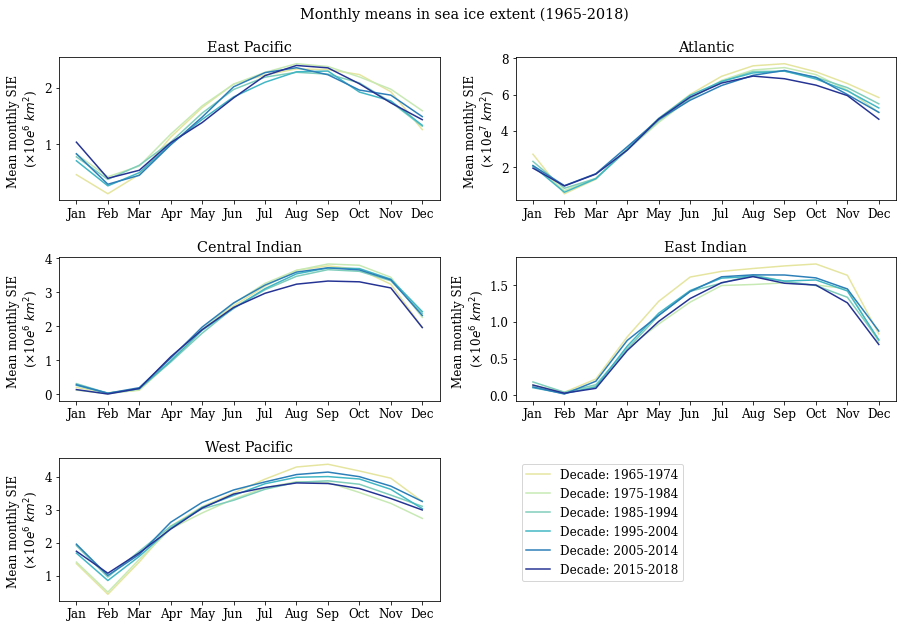

In [56]:
#Defining folder to save figure
out_folder = varDict['mean_sector_time_series']
os.makedirs(out_folder, exist_ok = True)

#Initialising figure
fig = plt.figure(figsize = (15, 10))

#Define decade start and color palette
dec_start = np.arange(1965, 2018, 10)
dec_colors = ['#e5e5a0', '#c7e9b4', '#7fcdbb', 
              '#41b6c4', '#2c7fb8', '#253494']

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

# Define max and min values for y axis
# maxval = []
# minval = []
# for sec in clipped_SIE:
#     maxval.append(clipped_SIE[sec].values.max())
#     minval.append(clipped_SIE[sec].values.min())
# #Calculating max and min values to the nearest ten
# maxval, minval = [(np.ceil(max(maxval)) + (1e9 - np.ceil(max(maxval))%1e9)), 
#                   (np.floor(min(minval)))]

#Create grid to show plots
gs = gridspec.GridSpec(nrows = 3, ncols = 2)

#Change the width between each plot
gs.update(wspace = 0.2, hspace = 0.4)

#Empty list to store axes 
ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, sec in enumerate(clipped_SIE):
    #Add each subplot
    ax[sec] = fig.add_subplot(gs[i])
    for j, dec in enumerate(dec_start):
        data = clipped_SIE[sec].sel(time = slice(str(dec), str(dec+9)))*1e-6
        max_yr = data.time.dt.year.values.max()
        data = data.groupby('time.month').mean('time')
        data.plot(ax = ax[sec], color = dec_colors[j], label = f'Decade: {dec}-{max_yr}')
    #Remove x axis label
    ax[sec].set_xlabel('')
    #Setting title for each subplot
    ax[sec].set_title(f'{sec}')
    #Show all ticks along the x axis
    plt.xticks(np.arange(1, 13))
    #Label x ticks as months
    ax[sec].set_xticklabels(calendar.month_abbr[1:])
    #Set y axis limits
    # ax[sec].set_ylim(minval*1e-6, (maxval*1e-6))
    #Get remove scientific notation from y axis and include it in label 
    exp_yaxis = np.floor(np.log10(max(ax[sec].get_yticks()))).astype(int)
    plt.ylabel('Mean monthly SIE \n' + r'($\times$10$e^{}$ $km^2$)'.format(exp_yaxis))
    ax[sec].yaxis.get_offset_text().set_visible(False)

ax['legend'] = fig.add_subplot(gs[5])
h, l = ax[sec].get_legend_handles_labels()
ax['legend'].legend(h, l, loc = 'upper left')
[s.set_visible(False) for s in ax['legend'].spines.values()]
[t.set_visible(False) for t in ax['legend'].get_xticklines()]
[t.set_visible(False) for t in ax['legend'].get_yticklines()]
ax['legend'].yaxis.set_tick_params(labelleft = False)
ax['legend'].xaxis.set_tick_params(labelbottom = False)

#Adding title to overall figure
fig.suptitle('Monthly means in sea ice extent (1965-2018)', y = 0.95)

#Saving figure
fn = 'MonthlyMeans_MEASOsectors_SeaIceExtent_1965-2018.png'
plt.savefig(os.path.join(out_folder, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

## Identifying extreme SIE values

In [9]:
#Calculate climatological means and 90th percentile per sector and season
clim = {}
per90 = {}
per10 = {}

for key in clipped_SIE:
    clim[key] = clipped_SIE[key].sel(time = slice('1979', '2008')).groupby('time.month').mean()
    p90 = clipped_SIE[key].quantile(.9).values.tolist()
    per90[key] = xr.DataArray(data = [p90]*(len(clipped_SIE[key].time)),
                 dims = 'time', 
                 coords = {'time': clipped_SIE[key].time.values})
    p10 = clipped_SIE[key].quantile(.1).values.tolist()
    per10[key] = xr.DataArray(data = [p10]*(len(clipped_SIE[key].time)),
                 dims = 'time', 
                 coords = {'time': clipped_SIE[key].time.values})

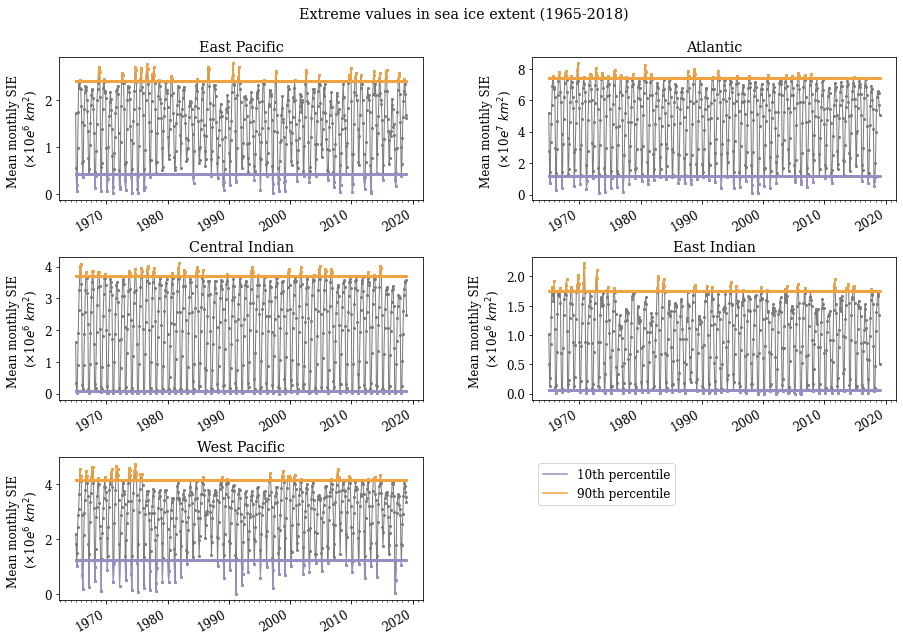

In [57]:
folder_out = varDict['mean_sector_time_series']
os.makedirs(folder_out, exist_ok = True)

#Initialising figure
fig = plt.figure(figsize = (15, 10))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Create grid to show plots
gs = gridspec.GridSpec(nrows = 3, ncols = 2)

#Change the width between each plot
gs.update(wspace = 0.3, hspace = 0.4)

#Empty list to store axes 
ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, sec in enumerate(clipped_SIE):
    #Add each subplot
    ax[sec] = fig.add_subplot(gs[i])
    
    #Plotting values
    (per10[sec]*1e-6).plot(ax = ax[sec], color = '#998ec3', label = '10th percentile')
    (per90[sec]*1e-6).plot(ax = ax[sec], color = '#f1a340', label = '90th percentile')
    (clipped_SIE[sec]*1e-6).plot(ax = ax[sec], color = '#7b7b7b', lw = 1, marker = '.',
                                markersize = 4)
    ax[sec].fill_between(per90[sec].time, per90[sec]*1e-6,
                xr.where((clipped_SIE[sec]*1e-6) > per90[sec]*1e-6, 
                         (clipped_SIE[sec]*1e-6), np.nan),
                color = '#f1a340')
    xr.where((clipped_SIE[sec]*1e-6) > per90[sec]*1e-6, 
                             (clipped_SIE[sec]*1e-6), per90[sec]*1e-6).plot(ax = ax[sec], 
                                                                            color = '#f1a340', 
                                                                            lw = 1, marker = '.',
                                                                            markersize = 4)
    ax[sec].fill_between(per10[sec].time, 
                    xr.where((clipped_SIE[sec]*1e-6) < per10[sec]*1e-6, 
                             (clipped_SIE[sec]*1e-6), np.nan),
                    per10[sec]*1e-6, color = '#998ec3', edgecolor = '#998ec3')
    xr.where((clipped_SIE[sec]*1e-6) < per10[sec]*1e-6, 
                             (clipped_SIE[sec]*1e-6), per10[sec]*1e-6).plot(ax = ax[sec], 
                                                                            color = '#998ec3', 
                                                                            lw = 1, marker = '.',
                                                                            markersize = 4)
    
    #Remove x axis label
    ax[sec].set_xlabel('')
    ax[sec].set_ylabel('Sea ice extent ($km^{2}$/year)')
    #Setting title for each subplot
    ax[sec].set_title(f'{sec}')
    #Get remove scientific notation from y axis and include it in label 
    exp_yaxis = np.floor(np.log10(max(ax[sec].get_yticks()))).astype(int)
    plt.ylabel('Mean monthly SIE \n' + r'($\times$10$e^{}$ $km^2$)'.format(exp_yaxis))
    ax[sec].yaxis.get_offset_text().set_visible(False)
    ax[sec].xaxis.set_minor_locator(AutoMinorLocator(n = 12))
    
ax['legend'] = fig.add_subplot(gs[5])
h, l = ax[sec].get_legend_handles_labels()
ax['legend'].legend(h, l, loc = 'upper left')
[s.set_visible(False) for s in ax['legend'].spines.values()]
[t.set_visible(False) for t in ax['legend'].get_xticklines()]
[t.set_visible(False) for t in ax['legend'].get_yticklines()]
ax['legend'].yaxis.set_tick_params(labelleft = False)
ax['legend'].xaxis.set_tick_params(labelbottom = False)

#Adding title to overall figure
fig.suptitle('Extreme values in sea ice extent (1965-2018)', y = 0.95)

#Saving figure
fn = 'ExtremeValues_MEASO_1965-218.png'
plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

# Boxplots

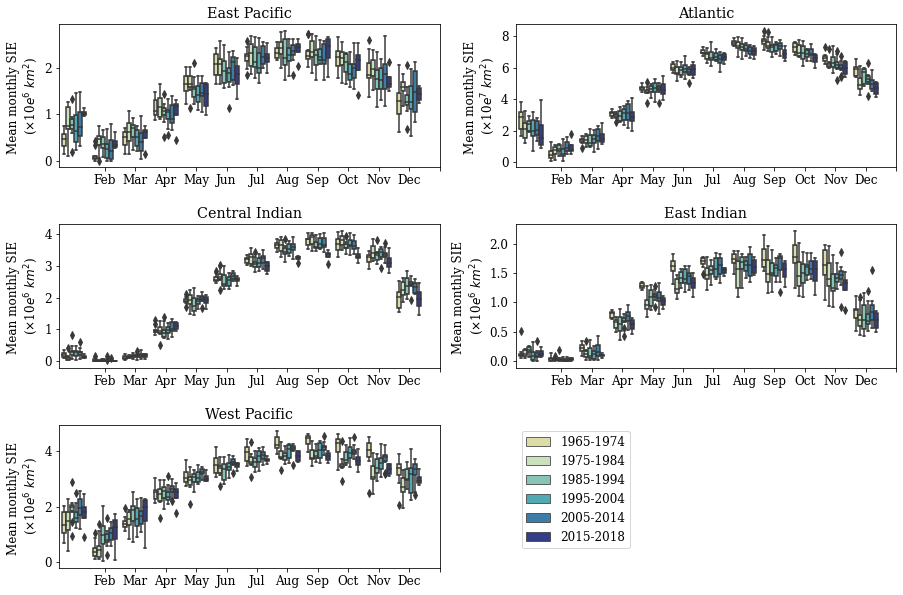

In [58]:
out_folder = varDict['mean_sector_time_series']

import seaborn as sns

#Set decade groups
dec = np.repeat(['1965-1974', '1975-1984', '1985-1994', '1995-2004', '2005-2014'], 120)
x = np.repeat(['2015-2018'], 48)
dec = np.append(dec, x)

#Initialising figure
fig = plt.figure(figsize = (15, 10))

#Define decade start and color palette
dec_colors = sns.set_palette(palette = ['#e5e5a0', '#c7e9b4', '#7fcdbb', 
                                        '#41b6c4', '#2c7fb8', '#253494'])

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Create grid to show plots
gs = gridspec.GridSpec(nrows = 3, ncols = 2)

#Change the width between each plot
gs.update(wspace = 0.2, hspace = 0.4)

#Empty list to store axes 
ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, sec in enumerate(clipped_SIE):
    #Add each subplot
    ax[sec] = fig.add_subplot(gs[i])
    # for j, d in enumerate(np.unique(dec)):
    df = pd.DataFrame({'SIE': (clipped_SIE[sec][1:]*1e-6).values,
                       'month': [calendar.month_abbr[i] for i in clipped_SIE[sec][1:].time.dt.month.values],
                       'decade': dec})
    df = df.assign(merged_groups = (df.month + '_' + df.decade).to_list())
    sns.boxplot(x = 'month', y = 'SIE', hue = 'decade', data = df, ax = ax[sec],
                   palette = dec_colors)
    plt.legend([], [], frameon = False)
    
    #Remove x axis label
    ax[sec].set_xlabel('')
    #Setting title for each subplot
    ax[sec].set_title(f'{sec}')
    #Show all ticks along the x axis
    plt.xticks(np.arange(1, 13))
    #Get remove scientific notation from y axis and include it in label 
    exp_yaxis = np.floor(np.log10(max(ax[sec].get_yticks()))).astype(int)
    plt.ylabel('Mean monthly SIE \n' + r'($\times$10$e^{}$ $km^2$)'.format(exp_yaxis))
    ax[sec].yaxis.get_offset_text().set_visible(False)

ax['legend'] = fig.add_subplot(gs[5])
h, l = ax[sec].get_legend_handles_labels()
ax['legend'].legend(h, l, loc = 'upper left')
[s.set_visible(False) for s in ax['legend'].spines.values()]
[t.set_visible(False) for t in ax['legend'].get_xticklines()]
[t.set_visible(False) for t in ax['legend'].get_yticklines()]
ax['legend'].yaxis.set_tick_params(labelleft = False)
ax['legend'].xaxis.set_tick_params(labelbottom = False)


#Saving figure
fn = 'MonthlyMeansBoxplots_MEASOsectors_SeaIceExtent_1965-2018.png'
plt.savefig(os.path.join(out_folder, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

In [46]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('SIE ~ C(month) + C(decade) + C(month):C(decade)', data = df).fit()
sm.stats.anova_lm(model, typ = 2)

sum_sq     df            F        PR(>F)
C(month)            3.350743e+27   11.0  1712.162048  0.000000e+00
C(decade)           7.823666e+24    5.0     8.795019  4.694519e-08
C(month):C(decade)  1.544806e+25   55.0     1.578730  6.418941e-03
Residual            1.024769e+26  576.0          NaN           NaN

In [66]:
# from statsmodels.stats.multicomp import pairwise_tukeyhsd
print(pairwise_tukeyhsd(endog =  df['SIE'], groups = df['merged_groups'], alpha = 0.05))
# print(pairwise_tukeyhsd(endog =  df['SIE'], groups = df['month'], alpha = 0.05))

                         Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
    group1        group2          meandiff      p-adj         lower               upper        reject
-----------------------------------------------------------------------------------------------------
Apr_1965-1974 Apr_1975-1984  -105828221899.3999    0.9  -895010096215.1489   683353652416.3491  False
Apr_1965-1974 Apr_1985-1994  -112525134626.0996    0.9  -901707008941.8486   676656739689.6494  False
Apr_1965-1974 Apr_1995-2004   -58125298191.8999    0.9  -847307172507.6489   731056576123.8491  False
Apr_1965-1974 Apr_2005-2014    67669490984.8003    0.9  -721512383330.9487   856851365300.5493  False
Apr_1965-1974 Apr_2015-2018  -120795436160.7998    0.9 -1164784925480.4517   923194053158.8522  False
Apr_1965-1974 Aug_1965-1974     4517101583729.2  0.001   3727919709413.451   5306283458044.949   True
Apr_1965-1974 Aug_1975-1984     4286621778943.2  0.001   3497439904627.451   50758

## Splitting data into regions and seasons

In [9]:
seasonName = {'Summer': [12, 1, 2], 'Autumn': [3, 4, 5], 
              'Winter': [6, 7, 8], 'Spring': [9, 10, 11]}

In [39]:
#Ensuring output folder exists
out_folder = os.path.join(varDict['clipped_data'], 'Seasons')
#Ensuring file exists
os.makedirs(out_folder, exist_ok = True)

#Create empty list to hold data split into seasons and regions
seasons_SIE = {}

for sec in clipped_SIE:
    #Range of years included in data
    minY = clipped_SIE[sec].time.dt.year.values.min()
    maxY = clipped_SIE[sec].time.dt.year.values.max()
    for sea in seasonName:
        data = []
        for i, m in enumerate(clipped_SIE[sec].time.dt.month.values.tolist()):
            if m in seasonName[sea]:
                data.append(clipped_SIE[sec][i])
        seasons_SIE[f'{sec}_{sea}'] = xr.concat(data, dim = 'time')
        fn = f'SeaIceExtent_{sec}_{sea}_{minY}-{maxY}.nc'
        seasons_SIE[f'{sec}_{sea}'].to_netcdf(os.path.join(out_folder, fn))

### Loading data from disk to avoid recalculation

In [48]:
#Get a list of files with clipped data per sector and season
in_files = sorted(glob(os.path.join(varDict['clipped_data'], 'Seasons/*.nc')))

#Create empty list to hold data split into seasons and regions
seasons_SIE = {}

for sec in sectorNames:
    files = [file for file in in_files if sec in file]
    for sea in seasonName:
        file = [f for f in files if sea in f][0]
        seasons_SIE[f'{sec}_{sea}'] = xr.open_dataarray(file)

## Calculating trends over time

In [50]:
#Folder where linear trends will be saved
dir_out = os.path.join(varDict['linear_trends'], 'MEASO')
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Creating empty dictionary to store linear regression results
LM_sea_sec = {}

#Calculating linear trend for each season
for key in seasons_SIE:
    #Extracting years to calculate linear trends
    time_ind = [i for i, j in enumerate(seasons_SIE[key].time)]
    #Extract values from SIC data and create a vector
    vals = seasons_SIE[key].values.tolist()

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = zsf.lm_yr(vals, time_ind)

    #Saving results in dictionary
    LM_sea_sec[key] = {'slope': slope,
                       'intercept': intercept,
                       'r': r,
                       'p': p,
                       'se': se}
    
#Saving outputs
#Define file name
    minY = seasons_SIE[key].time.dt.year.values.min()
    maxY = seasons_SIE[key].time.dt.year.values.max()
    fn = f'LinearTrends_SIE_AllSectors_{minY}-{maxY}.csv'

#Saving as csv
# pd.DataFrame(LM_sea_sec).to_csv(os.path.join(dir_out, fn))

In [223]:
pd.DataFrame(LM_sea_sec)

East Pacific_Summer  East Pacific_Autumn  East Pacific_Winter  \
slope             1.251354e+09        -1.095985e+09        -5.568189e+08   
intercept         7.215100e+11         1.136121e+12         2.219166e+12   
r                 1.060725e-01        -1.057350e-01        -8.452583e-02   
p                 1.777789e-01         1.805308e-01         2.848794e-01   
se                9.245011e+08         8.148628e+08         5.189285e+08   

           East Pacific_Spring  Atlantic_Summer  Atlantic_Autumn  \
slope            -1.202849e+09    -1.975964e+09     1.802333e+09   
intercept         2.170134e+12     2.940510e+12     2.885634e+12   
r                -1.625071e-01    -4.727929e-02     6.239397e-02   
p                 3.881753e-02     5.489652e-01     4.302494e-01   
se                5.773872e+08     3.290101e+09     2.279215e+09   

           Atlantic_Winter  Atlantic_Spring  Central Indian_Summer  \
slope        -2.410926e+09    -4.120112e+09           7.865790e+08   
intercept     6.818772e+12     7.212693e+12           7.727709e+11   
r            -1.648515e-01    -3.103357e-01           3.624968e-02   
p             3.605261e-02     5.843861e-05           6.459511e-01   
se            1.140376e+09     9.977630e+08           1.708991e+09   

           Central Indian_Autumn  Central Indian_Winter  \
slope               8.525846e+08          -5.938602e+08   
intercept           9.422775e+11           3.146009e+12   
r                   5.486614e-02          -6.394828e-02   
p                   4.880291e-01           4.188293e-01   
se                  1.226644e+09           7.326651e+08   

           Central Indian_Spring  East Indian_Summer  East Indian_Autumn  \
slope              -9.628149e+08       -1.011823e+08       -3.269521e+08   
intercept           3.642233e+12        3.283683e+11        6.766971e+11   
r                  -1.660661e-01       -1.307216e-02       -3.729829e-02   
p                   3.468673e-02        8.684585e-01        6.374853e-01   
se                  4.519904e+08        6.099681e+08        6.925209e+08   

           East Indian_Winter  East Indian_Spring  West Pacific_Summer  \
slope           -3.889387e+08       -1.020435e+09         2.964174e+09   
intercept        1.574901e+12        1.627037e+12         1.603930e+12   
r               -9.290907e-02       -1.880248e-01         1.316068e-01   
p                2.396238e-01        1.657311e-02         9.401200e-02   
se               3.295190e+08        4.213999e+08         1.759618e+09   

           West Pacific_Autumn  West Pacific_Winter  West Pacific_Spring  
slope             1.039602e+09        -1.492071e+08        -1.107502e+09  
intercept         2.299921e+12         3.745753e+12         3.912845e+12  
r                 6.963643e-02        -1.919312e-02        -1.192708e-01  
p                 3.785705e-01         8.084554e-01         1.306061e-01  
se                1.177375e+09         6.144746e+08         7.288514e+08

In [50]:
# round(LM_sea_sec.intercept.sel(season = SI_seasons[0]).values.tolist(), 3)
p = round(LM_sea_sec['East Pacific_Spring']['p'], 3)
if p == 0:
    p = '<0.001'

print(p)

if (isinstance(p, float) and p < 0.05) or isinstance(p, str):
    print('yes')
else:
    print('no')

0.039
yes


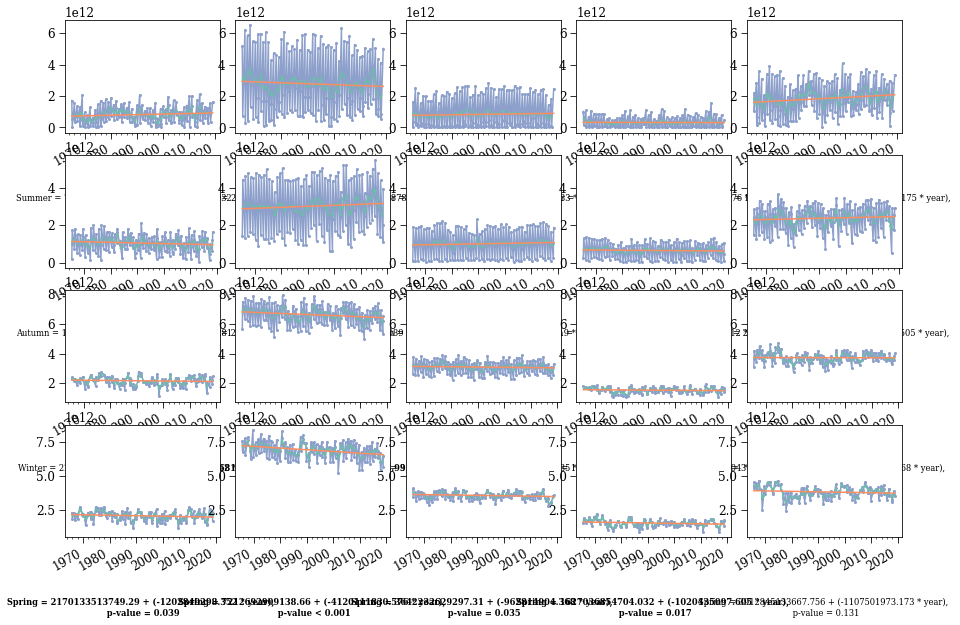

In [51]:
#Initialising figure
fig = plt.figure(figsize = (15, 12))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

gs = gridspec.GridSpec(nrows = len(sectorNames), ncols = 1)

for row, sea in enumerate(seasonName):
    axes = np.empty(shape = (1, len(sectorNames)), dtype = object)
    season = gridspec.GridSpecFromSubplotSpec(1, len(sectorNames),
                                              subplot_spec = gs[row], 
                                              wspace = 0.1)
    for col, sec in enumerate(sectorNames):
        ax = plt.Subplot(fig, season[0, col], sharey = axes[0, 0]) 
        fig.add_subplot(ax)
        axes[0, col] = ax
        seasons_SIE[f'{sec}_{sea}'].plot(ax = ax, linewidth = 1.5, 
                                         marker = 'o', color = '#8da0cb',
                                        markersize = 2)
        seasons_SIE[f'{sec}_{sea}'].rolling(time = 3, center = True).mean().\
        plot(ax = ax, linestyle = '--', linewidth = 1.5, color = '#66c2a5')
    
        time_ind = np.arange(0, len(seasons_SIE[f'{sec}_{sea}'].time))
        time = seasons_SIE[f'{sec}_{sea}'].time
        intercept = round(LM_sea_sec[f'{sec}_{sea}']['intercept'], 3)
        slope = round(LM_sea_sec[f'{sec}_{sea}']['slope'], 3)
        plt.plot(time, intercept+(slope*time_ind), linewidth = 1.5, 
                 color = '#fc8d62')
        
        #Prepare equation
        p = round(LM_sea_sec[f'{sec}_{sea}']['p'], 3)
        if p == 0:
            p = '< 0.001'
               
        if isinstance(p, str):
            eq = f'{sea} = {intercept} + ({slope} * year), \n p-value {p}'
        else:
            eq = f'{sea} = {intercept} + ({slope} * year), \n p-value = {p}'
        
        ax.set_title('')
        if (isinstance(p, float) and p < 0.05) or isinstance(p, str):
            ax.set_xlabel(f'\n\n{eq}', fontsize = 'x-small', fontweight = 'bold')
        else:
            ax.set_xlabel(f'\n\n{eq}', fontsize = 'x-small')
        ax.set_ylabel('')
        #Increasing the size of the x and y axes ticks
        ax.tick_params(length = 6)
        # For the minor ticks, use no labels; five minor ticks to be included between each major tick pair 
        ax.xaxis.set_minor_locator(AutoMinorLocator(n = 5))
# seasons_SIE['Atlantic_Autumn'].plot()
# seasons_SIE['Atlantic_Autumn'].rolling(time = 3, center = True).mean().plot()
# plt.plot(seasons_SIE['Atlantic_Autumn'].time, [intercept+(slope*t) for t in t_ind])
# print(slope*1e-6)

In [257]:
anom = seasons_SIE[key]-clim[key]
anom#.plot()

<xarray.DataArray (time: 162, month: 3)>
array([[ 5.72853313e+11,  7.03760459e+11,  9.83070362e+11],
       [ 3.40810019e+11,  4.71717165e+11,  7.51027068e+11],
       [ 1.40358863e+11,  2.71266009e+11,  5.50575912e+11],
       [ 5.01793385e+11,  6.32700531e+11,  9.12010434e+11],
       [ 3.23690590e+11,  4.54597736e+11,  7.33907639e+11],
       [ 7.66060323e+10,  2.07513178e+11,  4.86823081e+11],
       [ 6.73402384e+11,  8.04309530e+11,  1.08361943e+12],
       [ 6.74985783e+11,  8.05892929e+11,  1.08520283e+12],
       [ 9.06283238e+10,  2.21535470e+11,  5.00845373e+11],
       [ 3.43003341e+10,  1.65207480e+11,  4.44517383e+11],
       [-6.23052413e+11, -4.92145267e+11, -2.12835364e+11],
       [-1.45830001e+12, -1.32739286e+12, -1.04808296e+12],
       [ 2.98547867e+11,  4.29455013e+11,  7.08764916e+11],
       [-6.23207373e+10,  6.85864087e+10,  3.47896312e+11],
       [-2.46463136e+11, -1.15555990e+11,  1.63753913e+11],
       [ 3.76278154e+11,  5.07185300e+11,  7.86495202e+11],
       [ 4.71287537e+11,  6.02194683e+11,  8.81504586e+11],
       [ 5.85533141e+11,  7.16440287e+11,  9.95750190e+11],
       [ 5.72600607e+11,  7.03507753e+11,  9.82817655e+11],
       [ 5.81277703e+11,  7.12184849e+11,  9.91494752e+11],
...
       [-2.22937649e+11, -9.20305031e+10,  1.87279400e+11],
       [-7.28736933e+11, -5.97829787e+11, -3.18519884e+11],
       [ 2.48210386e+11,  3.79117532e+11,  6.58427435e+11],
       [ 2.90680517e+11,  4.21587663e+11,  7.00897566e+11],
       [-3.17333673e+11, -1.86426527e+11,  9.28833755e+10],
       [ 3.82083776e+11,  5.12990922e+11,  7.92300825e+11],
       [ 7.41533189e+10,  2.05060465e+11,  4.84370368e+11],
       [-2.72677780e+11, -1.41770634e+11,  1.37539269e+11],
       [-2.31216658e+11, -1.00309512e+11,  1.79000391e+11],
       [-3.55324953e+11, -2.24417807e+11,  5.48920955e+10],
       [-7.29811319e+11, -5.98904173e+11, -3.19594270e+11],
       [ 6.11078183e+10,  1.92014964e+11,  4.71324867e+11],
       [ 1.25136726e+11,  2.56043872e+11,  5.35353775e+11],
       [-3.99339455e+11, -2.68432309e+11,  1.08775937e+10],
       [-3.80980448e+11, -2.50073302e+11,  2.92366005e+10],
       [-7.09990113e+11, -5.79082967e+11, -2.99773065e+11],
       [-8.44229852e+11, -7.13322706e+11, -4.34012803e+11],
       [-2.11197681e+10,  1.09787378e+11,  3.89097281e+11],
       [-2.37454038e+11, -1.06546892e+11,  1.72763011e+11],
       [-4.16581555e+11, -2.85674409e+11, -6.36450622e+09]])
Coordinates:
  * time     (time) datetime64[ns] 1965-09-30T12:00:00 ... 2018-11-30T12:00:00
    region   <U12 'West Pacific'
  * month    (month) int64 9 10 11

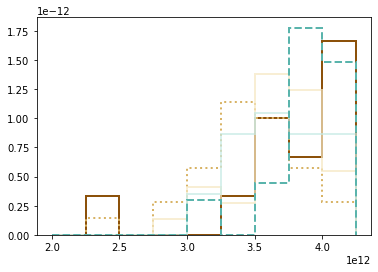

In [127]:
# t65_74 = seasons_SIE[key].sel(time = slice('1965', '1974'))
# t75_84 = seasons_SIE[key].sel(time = slice('1975', '1984'))
# t85_94 = seasons_SIE[key].sel(time = slice('1985', '1994'))
# t95_04 = seasons_SIE[key].sel(time = slice('1995', '2004'))
# t05_14 = seasons_SIE[key].sel(time = slice('2005', '2014'))

# rangeV = np.arange(seasons_SIE[key].values.min(), seasons_SIE[key].values.max(), 0.5e12)
bins = np.arange(2e12, 4.5e12, 0.25e12)

hist6070 = plt.hist(t65_74, bins = bins, density = True, histtype = 'step',
         color = '#8c510a', lw = 2)
hist7080 = plt.hist(t75_84, bins = bins, density = True, histtype = 'step', 
        color = '#d8b365', ls = ':', lw = 2)
hist8090 = plt.hist(t85_94, bins = bins, density = True, histtype = 'step', 
        color = '#f6e8c3', lw = 2, alpha = 0.7)
hist9000 = plt.hist(t95_04, bins = bins, density = True, histtype = 'step', 
        color = '#c7eae5', lw = 2, alpha = 0.7)
hist0010 = plt.hist(t05_14, bins = bins, density = True, histtype = 'step', 
        color = '#5ab4ac', lw = 2, ls = '--')

# minV = seasons_SIE[key].values.min()
# maxV = seasons_SIE[key].values.max()
# print(minV, maxV)

# from scipy import stats
# kernel = stats.gaussian_kde(seasons_SIE['Central Indian_Autumn'])
# Z = kernel(np.arange(minV, maxV+1))
# Z.plot()

In [137]:
# from scipy import stats
# stats.kstest(hist6070[0].tolist(), hist7080[0].tolist(), alternative = 'two-sided')
stats.kstest(hist6070[0].tolist(), hist8090[0].tolist(), alternative = 'two-sided')

KstestResult(statistic=0.1111111111111111, pvalue=1.0)

## Calculating linear trends by longitude

In [234]:
meanlon = SIE.sum('yt_ocean', skipna = True, min_count = 1)
meanlon = meanlon.fillna(0)

In [241]:
meanlon_clim = meanlon.sel(time = slice('1978-12', '2008-11'))

seasons_SIE = {}

for month in range(1, 13):
    y = []
    for i, m in enumerate(meanlon_clim.time.dt.month.values.tolist()):
        if month == m:
            y.append(meanlon_clim[i])
    seasons_SIE[calendar.month_abbr[month]] = xr.concat(y, dim = 'time')

In [242]:
#Folder where linear trends will be saved
dir_out = varDict['linear_trends']
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Calculating linear trend for each season
for m in calendar.month_abbr[1:]:
    #Define file name
    fn = f'LinearTrend_SIC-lon_{m}_1979-2008.nc'

    #Extracting years to calculate linear trends
    time_ind = np.arange(0, len(seasons_SIE[m].time))
    #Extract values from SIC data and create a vector
    vals = seasons_SIE[m].values.reshape(len(time_ind), -1)

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = time_ind)

    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(seasons_SIE[m][0].shape), 
                          dims = ["xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SIE[m].xt_ocean.values),
                          name = "coefficients")

    pval_r = xr.DataArray(data = p.reshape(seasons_SIE[m][0].shape), 
                          dims = ["xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SIE[m].xt_ocean.values),
                          name = "p_values")

    LM_results = xr.merge([coef_r, pval_r])

    #Saving outputs
    LM_results.to_netcdf(os.path.join(dir_out, fn))

In [79]:
filelist = glob(os.path.join(varDict['linear_trends'], '*.nc'))

LM_results = {}

for m in calendar.month_abbr[1:]:
    file = [file for file in filelist if m in file]
    LM_results[m] = xr.open_dataset(file[0])

In [80]:
x = []
y = []
for m in LM_results:
    x.append(LM_results[m].coefficients.expand_dims({'month': [m]}))
    y.append(LM_results[m].p_values.expand_dims({'month': [m]}))

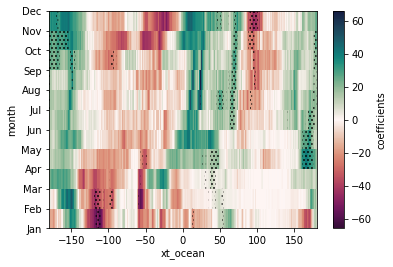

In [99]:
# coef = xr.concat(x, dim = 'month')
pval = xr.concat(y, dim = 'month')
pval = xr.where(pval <= 0.05, True, False)
(coef*1e-6).plot(cmap = cm.cm.curl_r)
pval.where(pval == 1, np.nan).plot.contourf(hatches = ['...'], colors = 'none', add_colorbar = False)

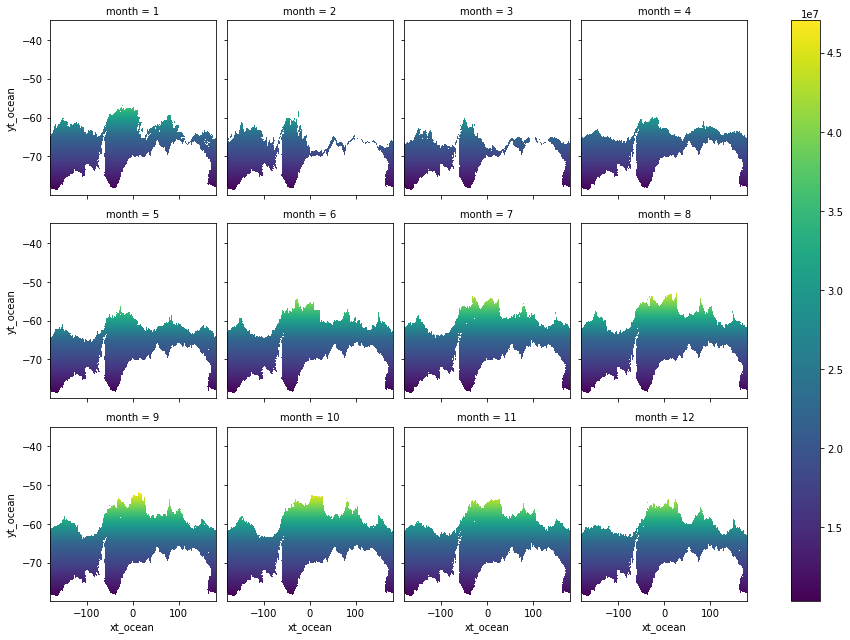

In [216]:
SIE.groupby('time.month').mean('time').plot(col = 'month', col_wrap = 4)

In [164]:
climdata = SIC.sel(time = slice('1978-12', '2008-11'))

seasons_SIC = {}

for season in seasonName.keys():
    y = []
    for i, m in enumerate(climdata.time.dt.month.values.tolist()):
        if m in seasonName[season]:
            y.append(climdata[i])
    seasons_SIC[season] = xr.concat(y, dim = 'time')

<xarray.DataArray (time: 90, xt_ocean: 3600)>
array([[14879445., 14879445., 14879445., ..., 14785931., 14841749.,
        14861374.],
       [15397852., 15397852., 15397852., ..., 15379647., 15379647.,
        15397852.],
       [16339954., 16339954., 16321923., ..., 16339954., 16339954.,
        16339954.],
       ...,
       [15616050., 15616050., 15616050., ..., 15616050., 15616050.,
        15616050.],
       [16213659., 16231711., 16231711., ..., 16213659., 16213659.,
        16213659.],
       [16357983., 16339954., 16321923., ..., 16394029., 16376007.,
        16376007.]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 1979-03-31T12:00:00 ... 2008-05-31T12:00:00
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9

In [94]:
# import statsmodels.api as sm
# decomposition = sm.tsa.seasonal_decompose(clipped_SIE['Atlantic'].drop('region').to_pandas(), model='additive')
# decomposition

# decomposition2 = sm.tsa.seasonal_decompose(x.sort_index(inplace = True), model='additive')
# decomposition2.plot()

# sm.tsa.seasonal_decompose(clipped_SIE['Atlantic'].groupby('time.season'), model = 'additive')

clipped_SIE['Atlantic'].drop('region').to_pandas()#['time']

# x = seasons_SIE['Atlantic_Autumn'].drop('region').to_pandas()
# # x.sort_index(inplace = True)
# x.sort_index(inplace = True)
# x

time
1964-12-31 12:00:00    5.177079e+12
1965-01-31 12:00:00    2.776212e+12
1965-02-28 12:00:00    7.035236e+11
1965-03-31 12:00:00    1.414288e+12
1965-04-30 12:00:00    3.345683e+12
                           ...     
2018-08-31 12:00:00    6.562940e+12
2018-09-30 12:00:00    6.433582e+12
2018-10-31 12:00:00    6.449174e+12
2018-11-30 12:00:00    5.673261e+12
2018-12-31 12:00:00    5.033518e+12
Length: 649, dtype: float64